In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import logging
from functools import partial
from itertools import combinations

import numpy as np
import jax
from jax import random
from jax import numpy as jnp
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import distrax
import wandb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import src.models as models
from src.models import make_PoG_Ens_loss, make_Reg_Ens_loss, make_PoN_Ens_loss
from src.models import make_PoG_Ens_plots, make_Reg_Ens_plots, make_PoN_Ens_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.comparison_figures_pog import get_config as get_pog_config
from experiments.configs.comparison_figures_reg_ens import get_config as get_reg_ens_config
from experiments.configs.comparison_figures_pon import get_config as get_pon_config
from src.models.pog import calculate_pog_loc_scale
from src.models.reg_ens import calculate_ens_loc_scale
from src.models.pon import normal_prod
from src.models.common import MembersLL

In [21]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [22]:
ENS_RETRAIN = False
POG_RETRAIN = False
PON_RETRAIN = False

In [23]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'reg_comparison_figures.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

True

## PoG Training

In [24]:
# MEMBERS_LL = MembersLL.GND
MEMBERS_LL = MembersLL.gaussian
BETA_START = 2.
BETA_END = 2.

In [25]:
config = get_pog_config()
config.model.members_ll_type = MEMBERS_LL.value
config.β_schedule.start = BETA_START
config.β_schedule.end = BETA_END

In [26]:
print(config)

batch_size: 500
dataset:
  heteroscedastic: false
  n_samples: 692
  noise_std: 0.25
  random_seed: 42
dataset_name: gen_simple_1d
epochs: 201
learning_rate: 0.0001
model:
  learn_weights: false
  members_ll_type: gaussian
  net:
    depth: 2
    hidden_size: 50
    out_size: 1
  noise: homo
  size: 5
model_name: PoG_Ens
optim:
  momentum: 0.9
  weight_decay: 0.0001
optim_name: sgdw
"\u03B2_schedule":
  end: 2.0
  name: sigmoid
  start: 2.0
  steps: 201



In [27]:
data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pog_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pog_model, state = setup_training(config, setup_rng, init_x, init_y)

    if POG_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            pog_model, state, config, rng, partial(make_PoG_Ens_loss, per_member_loss=True), partial(make_PoG_Ens_loss, per_member_loss=True), train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': '',
            },
            plot_fn=make_PoG_Ens_plots,
        )

        best_pog_states.append(best_state)

        save_checkpoint(f'dynNN_results/pog_model_{i}_{MEMBERS_LL.value}', best_state, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [28]:
# if POG_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/pog_models', best_pog_states, 1)

## Reg Ens training

In [29]:
config = get_reg_ens_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_ens_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    ens_model, state = setup_training(config, setup_rng, init_x, init_y)

    if ENS_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            ens_model, state, config, rng, make_Reg_Ens_loss, make_Reg_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': '',
            },
            plot_fn=make_Reg_Ens_plots,
        )

        best_ens_states.append(best_state)

        save_checkpoint(f'dynNN_results/ens_model_{i}', best_ens_states, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [30]:
# if ENS_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/ens_models', best_ens_states, 1, overwrite=True)

## PoN

In [31]:
config = get_pon_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pon_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pon_model, state = setup_training(config, setup_rng, init_x, init_y)

    if PON_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            pon_model, state, config, rng, make_PoN_Ens_loss, make_PoN_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': '',
            },
            plot_fn=make_PoN_Ens_plots,
        )

        best_pon_states.append(best_state)

        save_checkpoint(f'dynNN_results/pon_model_{i}', best_pon_states, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [32]:
# if PON_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/pon_models', best_pon_states, 1, overwrite=True)

## Paper Plots

In [33]:
# restored_pog_models = restore_checkpoint('dynNN_results/pog_models', 1)
restored_pog_models = {f'{i}': restore_checkpoint(f'dynNN_results/pog_model_{i}_{MEMBERS_LL.gaussian.value}', 1) for i in range(1)}
restored_pog_models_GND = {f'{i}': restore_checkpoint(f'dynNN_results/pog_model_{i}_{MEMBERS_LL.GND.value}', 1) for i in range(1)}
restored_ens_models = restore_checkpoint('dynNN_results/ens_model_0', 1)
# restored_ens_models = {f'{i}': restore_checkpoint(f'dynNN_results/ens_model_{i}', 1) for i in range(3)}
restored_pon_models = restore_checkpoint('dynNN_results/pon_model_0', 1)
# restored_pon_models = {f'{i}': restore_checkpoint(f'dynNN_results/pon_model_{i}', 1) for i in range(3)}

In [34]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


# matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [35]:
X_train, y_train = list(zip(*train_loader.dataset))

In [36]:
X_test, y_test = list(zip(*test_loader.dataset))

In [37]:
def uniform_entropy(loc, scale):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return uni.entropy()

def uniform_nll(loc, scale, y):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return -uni.log_prob(y)

In [38]:
def normal_entropy(loc, scale):
    norm = distrax.Normal(loc, scale)
    return norm.entropy()

def normal_nll(loc, scale, y):
    norm = distrax.Normal(loc, scale)
    return -norm.log_prob(y)

In [39]:
def mse(loc, y):
    return jnp.mean((loc - y)**2)

In [40]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'mse', 'nll'])
results_df

,model_name,n_members,random_seed,H,mse,nll


In [41]:
s = set(range(5))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

for (model, model_name) in [(pog_model, 'PoG'), (ens_model, 'Ens'), (pon_model, 'PoN'), (pog_model, 'PoG-GND')]:
    for i in range(1):
        if model_name == 'PoG':
            state = restored_pog_models[f'{i}']
        elif model_name == 'Ens':
            state = restored_ens_models[f'{i}']
        elif model_name == 'PoN':
            state = restored_pon_models[f'{i}']
        elif model_name == 'PoG-GND':
            state = restored_pog_models_GND[f'{i}']
        
        pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False, return_ens_preds=True,
            method=model.pred
        )
        _, (locs, scales) = jax.vmap(
            pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
        )(jnp.array(X_test))

        for indices in power_set:
            n_members = len(indices)

            if 'PoG' in model_name:
                loc, scale = calculate_pog_loc_scale(locs[indices, :, 0], scales[indices, :, 0])
                entropies = jax.vmap(uniform_entropy)(loc, scale)
                nlls_ = jax.vmap(uniform_nll)(loc, scale, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
            elif model_name == 'Ens':
                loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            elif model_name == 'PoN':
                loc, scale = normal_prod(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            
            errors = jax.vmap(mse)(loc, jnp.array(y_test))

            results_df = pd.concat([
                results_df,
                pd.DataFrame({
                    'model_name': [model_name],
                    'n_members': [n_members],
                    'random_seed': [i],
                    'H': [entropies.mean()],
                    'nll': [nlls.mean()],
                    'mse': [errors.mean()],
                })],
                ignore_index=True
            )

dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 4
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 5
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0

In [42]:
min_mse_df = results_df[results_df.n_members == 5][['model_name', 'random_seed', 'mse', 'nll']].rename(
    columns={'mse': 'final_mse', 'nll': 'final_nll'}
)
min_mse_df

,model_name,random_seed,final_mse,final_nll
30,PoG,0,0.03193928,0.054625638
61,Ens,0,0.030034311,0.27382958
92,PoN,0,0.030034311,0.27233982
123,PoG-GND,0,0.03182057,0.3664909


In [43]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['mse_diff'] = tmp_df['mse'] - tmp_df['final_mse'] 
tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
tmp_df

,model_name,n_members,random_seed,H,mse,nll,final_mse,final_nll,mse_diff,nll_diff
0,PoG,1,0,0.13664614,0.030165693,0.13664617,0.03193928,0.054625638,-0.0017735865,0.08202053
1,PoG,1,0,0.13664614,0.032101937,0.13664617,0.03193928,0.054625638,0.00016265735,0.08202053
2,PoG,1,0,0.13664614,0.035763014,0.13664615,0.03193928,0.054625638,0.0038237348,0.08202051
3,PoG,1,0,0.13664614,0.031322356,0.13664615,0.03193928,0.054625638,-0.000616923,0.08202051
4,PoG,1,0,0.13664614,0.030530985,0.13664617,0.03193928,0.054625638,-0.0014082938,0.08202053
...,...,...,...,...,...,...,...,...,...,...
119,PoG-GND,4,0,0.36880326,0.03190819,0.36880326,0.03182057,0.3664909,8.762255e-05,0.0023123622
120,PoG-GND,4,0,0.4606202,0.03404268,0.4606202,0.03182057,0.3664909,0.0022221096,0.094129294
121,PoG-GND,4,0,0.37643084,0.031360134,0.37643084,0.03182057,0.3664909,-0.0004604347,0.009939939
122,PoG-GND,4,0,0.4150055,0.036129545,0.41500553,0.03182057,0.3664909,0.0043089762,0.048514634


In [44]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'mse_diff': ['mean', 'std', 'count'],
    'mse': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
})
agg_df

H                  mse_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.710392  0.000000     5  0.000827  0.000708     5   
           2          0.711452  0.000467    10  0.000310  0.000293    10   
           3          0.711807  0.000405    10  0.000138  0.000186    10   
           4          0.711984  0.000294     5  0.000052  0.000120     5   
           5          0.712091       NaN     1  0.000000       NaN     1   
PoG        1          0.136646  0.000000     5  0.000038  0.002244     5   
           2          0.098681  0.010117    10 -0.000783  0.001033    10   
           3          0.079277  0.010067    10 -0.000548  0.000921    10   
           4          0.064651  0.008269     5 -0.000263  0.000759     5   
           5          0.052421       NaN     1  0.000000       NaN     1   
PoG-GND    1          0.630748  0.000000     5  0.025629  0.017768     5   
           2          0.506359  0.065332    10  0.009629  0.008965    10   
           3          0.440470  0.055679    10  0.004051  0.005630    10   
           4          0.397569  0.040278     5  0.001243  0.002000     5   
           5          0.366491       NaN     1  0.000000       NaN     1   
PoN        1          0.710392  0.000000     5  0.000827  0.000708     5   
           2          0.710392  0.000000    10  0.000310  0.000293    10   
           3          0.710392  0.000000    10  0.000138  0.000186    10   
           4          0.710392  0.000000     5  0.000052  0.000120     5   
           5          0.710392       NaN     1  0.000000       NaN     1   

                           mse                  nll_diff                      \
                          mean       std count      mean           std count   
model_name n_members                                                           
Ens        1          0.030861  0.000708     5  0.000215  1.459695e-03     5   
           2          0.030344  0.000293    10  0.000073  7.804625e-04    10   
           3          0.030172  0.000186    10  0.000032  5.104739e-04    10   
           4          0.030086  0.000120     5  0.000012  3.286855e-04     5   
           5          0.030034       NaN     1  0.000000           NaN     1   
PoG        1          0.031977  0.002244     5  0.082021  8.161702e-09     5   
           2          0.031156  0.001033    10  0.044900  9.573582e-03    10   
           3          0.031391  0.000921    10  0.025983  9.538039e-03    10   
           4          0.031676  0.000759     5  0.011802  7.825820e-03     5   
           5          0.031939       NaN     1  0.000000           NaN     1   
PoG-GND    1          0.057450  0.017768     5  0.264257  0.000000e+00     5   
           2          0.041449  0.008965    10  0.139868  6.533192e-02    10   
           3          0.035871  0.005630    10  0.073979  5.567898e-02    10   
           4          0.033063  0.002000     5  0.031078  4.027793e-02     5   
           5          0.031821       NaN     1  0.000000           NaN     1   
PoN        1          0.030861  0.000708     5  0.001705  1.459702e-03     5   
           2          0.030344  0.000293    10  0.000639  6.045929e-04    10   
           3          0.030172  0.000186    10  0.000284  3.833988e-04    10   
           4          0.030086  0.000120     5  0.000107  2.481376e-04     5   
           5          0.030034       NaN     1  0.000000           NaN     1   

                           nll                      
                          mean           std count  
model_name n_members                                
Ens        1          0.274045  1.459695e-03     5  
           2          0.273902  7.804625e-04    10  
           3          0.273861  5.104739e-04    10  
           4          0.273841  3.286855e-04     5  
           5          0.273830           NaN     1  
PoG        1   

In [45]:
agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
agg_df[('mse_diff', 'std_err')] = agg_df[('mse_diff', 'std')] / agg_df[('mse_diff', 'count')]
agg_df[('mse', 'std_err')] = agg_df[('mse', 'std')] / agg_df[('mse', 'count')]
agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
agg_df

H                  mse_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.710392  0.000000     5  0.000827  0.000708     5   
           2          0.711452  0.000467    10  0.000310  0.000293    10   
           3          0.711807  0.000405    10  0.000138  0.000186    10   
           4          0.711984  0.000294     5  0.000052  0.000120     5   
           5          0.712091       NaN     1  0.000000       NaN     1   
PoG        1          0.136646  0.000000     5  0.000038  0.002244     5   
           2          0.098681  0.010117    10 -0.000783  0.001033    10   
           3          0.079277  0.010067    10 -0.000548  0.000921    10   
           4          0.064651  0.008269     5 -0.000263  0.000759     5   
           5          0.052421       NaN     1  0.000000       NaN     1   
PoG-GND    1          0.630748  0.000000     5  0.025629  0.017768     5   
           2          0.506359  0.065332    10  0.009629  0.008965    10   
           3          0.440470  0.055679    10  0.004051  0.005630    10   
           4          0.397569  0.040278     5  0.001243  0.002000     5   
           5          0.366491       NaN     1  0.000000       NaN     1   
PoN        1          0.710392  0.000000     5  0.000827  0.000708     5   
           2          0.710392  0.000000    10  0.000310  0.000293    10   
           3          0.710392  0.000000    10  0.000138  0.000186    10   
           4          0.710392  0.000000     5  0.000052  0.000120     5   
           5          0.710392       NaN     1  0.000000       NaN     1   

                           mse                  nll_diff                      \
                          mean       std count      mean           std count   
model_name n_members                                                           
Ens        1          0.030861  0.000708     5  0.000215  1.459695e-03     5   
           2          0.030344  0.000293    10  0.000073  7.804625e-04    10   
           3          0.030172  0.000186    10  0.000032  5.104739e-04    10   
           4          0.030086  0.000120     5  0.000012  3.286855e-04     5   
           5          0.030034       NaN     1  0.000000           NaN     1   
PoG        1          0.031977  0.002244     5  0.082021  8.161702e-09     5   
           2          0.031156  0.001033    10  0.044900  9.573582e-03    10   
           3          0.031391  0.000921    10  0.025983  9.538039e-03    10   
           4          0.031676  0.000759     5  0.011802  7.825820e-03     5   
           5          0.031939       NaN     1  0.000000           NaN     1   
PoG-GND    1          0.057450  0.017768     5  0.264257  0.000000e+00     5   
           2          0.041449  0.008965    10  0.139868  6.533192e-02    10   
           3          0.035871  0.005630    10  0.073979  5.567898e-02    10   
           4          0.033063  0.002000     5  0.031078  4.027793e-02     5   
           5          0.031821       NaN     1  0.000000           NaN     1   
PoN        1          0.030861  0.000708     5  0.001705  1.459702e-03     5   
           2          0.030344  0.000293    10  0.000639  6.045929e-04    10   
           3          0.030172  0.000186    10  0.000284  3.833988e-04    10   
           4          0.030086  0.000120     5  0.000107  2.481376e-04     5   
           5          0.030034       NaN     1  0.000000           NaN     1   

                           nll                             H  mse_diff  \
                          mean           std count   std_err   std_err   
model_name n_members                                                     
Ens        1          0.274045  1.459695e-03     5  0.000000  0.000142   
           2          0.273902  7.804625e-04    10  0.000047  0.000029   
           3          0.273861  5.104739e-04    10  0.000041  0.00001

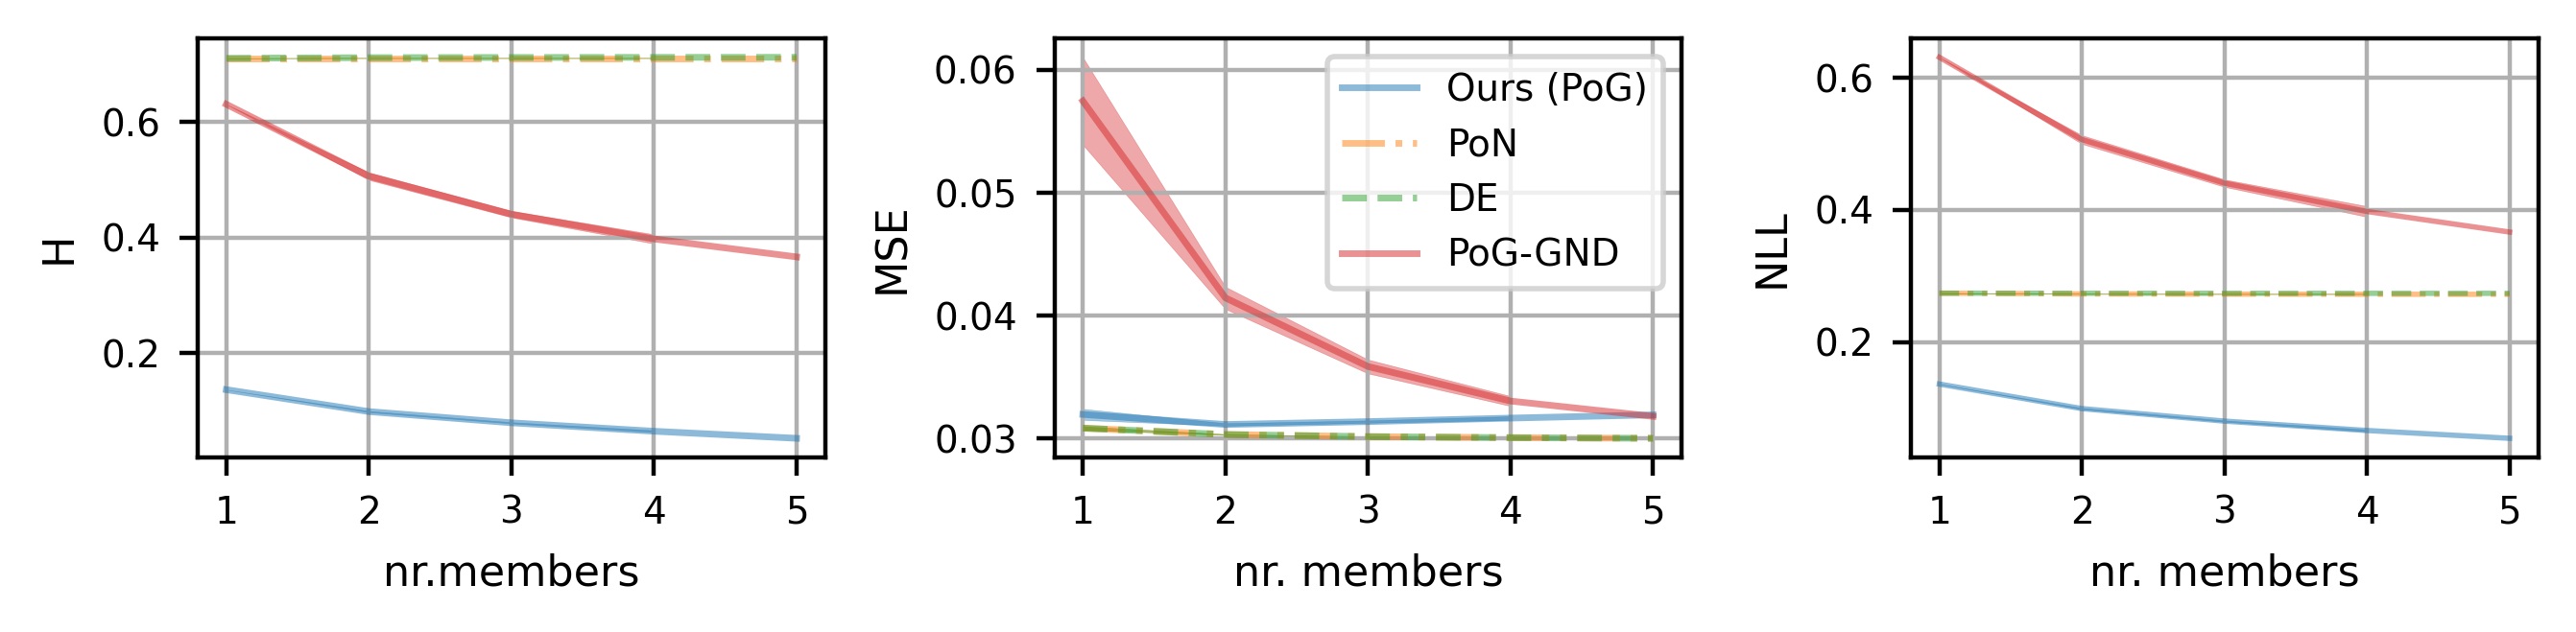

In [46]:
# matplotlib.style.use('default')
fig, axs = plt.subplots(1, 3, figsize=(text_width, text_width/4.), dpi=dpi, sharey=False, sharex=True, layout='tight')

names = {
    'PoG': 'Ours (PoG)',
    'Ens': 'DE',
    'PoN': 'PoN',
    "PoG-GND": "PoG-GND"
}

linestyles = {
    'PoG': '-',
    'Ens': '--',
    'PoN': '-.',
    "PoG-GND": "-"
}

H_df = agg_df['H'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens', "PoG-GND"]):
    x = H_df[H_df.model_name == model_name]['n_members']
    y = H_df[H_df.model_name == model_name]['mean']
    y_err = H_df[H_df.model_name == model_name]['std_err']

    axs[0].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5)
    axs[0].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[0].grid(0.3)
axs[0].set_ylabel('H')
axs[0].set_xlabel('nr.members')
axs[0].set_xticks([1, 2, 3, 4, 5])

err_df = agg_df['mse'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens', "PoG-GND"]):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[1].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5, label=names[model_name])
    axs[1].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[1].grid(0.3)
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('nr. members')
axs[1].set_xticks([1, 2, 3, 4, 5])

nll_df = agg_df[f'nll'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens', "PoG-GND"]):
    x = nll_df[nll_df.model_name == model_name]['n_members']
    y = nll_df[nll_df.model_name == model_name]['mean']
    y_err = nll_df[nll_df.model_name == model_name]['std_err']

    axs[2].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1., alpha=0.5, label=names[model_name])
    axs[2].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[2].grid(0.2)
axs[2].set_ylabel(f'NLL')
axs[2].set_xlabel('nr. members')
axs[2].set_xticks([1, 2, 3, 4, 5])
axs[1].legend()

plt.show()

# plt.savefig(f'toy_entropy_err_nll_evolution.pdf', dpi=dpi, bbox_inches='tight')

In [47]:
STATE = restored_pog_models_GND["0"]
MODEL = pog_model

# STATE = restored_ens_models["0"]
# MODEL = ens_model

# X_, y_ = X_test, y_test
X_, y_ = X_train, y_train


pred_fun = partial(
            MODEL.apply,
            {"params": STATE['params'], **STATE['model_state']},
            train=False, return_ens_preds=True,
            method=MODEL.pred
        )
_, (locs, scales) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(jnp.array(X_))

error = 0.
median = 0.
for i in range(5):
    mse_ = mse(locs[i, : ,:], jnp.array(y_))
    median_ = np.median(np.array(((locs[i, : ,:] - jnp.array(y_))**2)))
    print(mse_, median_)
    error += mse_
    median += median_
    
print(error/5, median/5)

0.06007818 0.032916285
0.05762434 0.028539155
0.094086155 0.058892526
0.04870056 0.023846248
0.04451275 0.020411637
0.061000403 0.032921170070767405


## Data plots

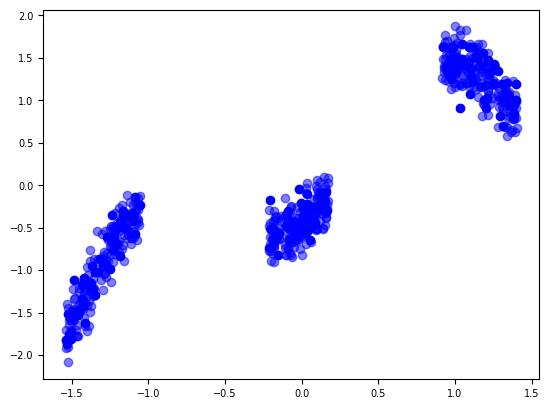

In [48]:
plt.scatter(X_train, y_train, alpha=0.5, color="blue")
plt.scatter(X_test, y_test, color="blue")
plt.show()

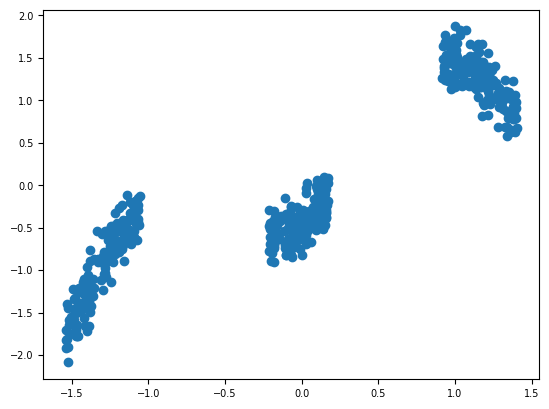

In [49]:
plt.scatter(X_train, y_train)
plt.show()

In [50]:
len(X_train)

496

In [51]:
len(y_train)

496

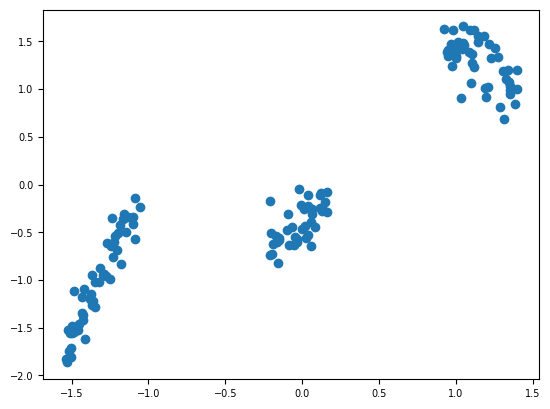

In [52]:
plt.scatter(X_test, y_test)
plt.show()